# WGAN with DCGAN layers
Code is mainly based upon the DCGAN implementation in the TensorFlow tutorials

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import memory_saving_gradients
# monkey patch tf.gradients to point to our custom version, with automatic checkpoint selection
tf.__dict__["gradients"] = memory_saving_gradients.gradients_memory
import librosa
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
#import imageio
import simpleaudio as sa
import math
import gc
from IPython import display
import time

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

# Hyperparameters

In [4]:
# Number for large nsynth-train dataset
TOTAL_NUM = 108978
# Number for small nsynth-test dataset
# TOTAL_NUM = 1689
BUFFER_SIZE = 2048
BATCH_SIZE = 50
PREFETCH_BUFFER_SIZE = BATCH_SIZE
# EPOCHS = 150
LAMBDA = 10
ALPHA = 0.001
BETA1 = 0.9
BETA2 = 0.999
CRITIC_UPDATES_PER_GEN_UPDATE = 5
noise_dim = 100
num_examples_to_generate = 16
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.Variable(tf.random_normal([num_examples_to_generate,
                                                 noise_dim]))

Instructions for updating:
Colocations handled automatically by placer.


# Make a dataset using TensorFlow's input pipeline

In [5]:
# Reading spectrograms from TFRecord file, making dataset
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'spectrogram': tf.FixedLenFeature([258300], dtype=float),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}

def _map(raw_data):
    return tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], [1025, 126, 2])

specs = tf.data.TFRecordDataset("spectrograms.tfrecord")
specs = specs.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
specs = specs.map(map_func=_map, num_parallel_calls=-1)
specs = specs.batch(batch_size=BATCH_SIZE)
specs = specs.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

In [6]:
# temporary test cell to test for memory issues
# iterator = specs.make_one_shot_iterator()
# real_images = iterator.get_next()
# while(True):
#     sess.run(real_images)
#     gc.collect()
#     print("-", end='')

# Define models

In [7]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(41*7*128, use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
    
        self.conv2 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 2), padding='same', use_bias=False)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
    
        self.conv3 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(5, 3), padding='same', use_bias=False)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2DTranspose(2, (5, 5), strides=(5, 3), padding='same', use_bias=False)
        
    def call(self, x, training=True):
        x = self.fc1(x)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.reshape(x, shape=(-1, 41, 7, 128))
        
        x = self.conv1(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv3(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.nn.tanh(self.conv4(x))  
        
        return x

In [8]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1, activation=None)

    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [9]:
def critic_loss(real_output, generated_output):
    return real_output - generated_output

In [10]:
def generator_loss(generated_output):
    return -1*generated_output

# Defining training
`buildgraph()` is largely based upon Zardinality's WGAN implementation and, to a smaller extent, the code from the paper introducing WGAN-GP

In [11]:
def generate_and_save_images(epoch):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = sess.run(generated)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')

    plt.savefig('image_at_epoch_{:.2f}.png'.format(epoch))
    plt.show()

In [12]:
def buildgraph():
    with tf.variable_scope('gen'):
        generator = Generator()
    with tf.variable_scope('critic'):
        critic = Critic()
    noise = tf.random_normal([BATCH_SIZE, noise_dim])
    epochs = tf.Variable(0.0, trainable=True, use_resource=True, dtype=tf.float64)
    increment = tf.placeholder(tf.float64)
    ranEpoch = tf.assign(epochs, tf.cast(tf.round((epochs + increment)*tf.cast(tf.pow(10, tf.cast(np.floor(np.log10(TOTAL_NUM))+2, tf.int32)), tf.float64))/tf.cast(tf.pow(10, tf.cast(np.floor(np.log10(TOTAL_NUM))+2, tf.int32)), tf.float64), tf.float64))
    getEpoch = epochs
    
    iterator = specs.make_one_shot_iterator()
    real_images = iterator.get_next() #tf.placeholder(tf.float32, shape=[BATCH_SIZE, 1025, 126, 2], name='images')
    fake_images = generator(noise)
    critic_real = critic(real_images)
    critic_fake = critic(fake_images)
    
    gen_cost = -tf.reduce_mean(critic_fake)
    critic_cost = tf.reduce_mean(critic_fake)-tf.reduce_mean(critic_real)
    alpha = tf.random_uniform(shape=[BATCH_SIZE, 1025, 126, 2], minval=0., maxval=1.)
    differences = fake_images-real_images
    interpolates = real_images+(alpha*differences)
    gradients = tf.gradients(critic(interpolates), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    critic_cost += LAMBDA*gradient_penalty
    
    gen_opt = tf.contrib.layers.optimize_loss(
        gen_cost, 
        None, learning_rate=1e-4, optimizer=tf.train.AdamOptimizer(ALPHA, BETA1, BETA2), variables=generator.trainable_variables)
        
    critic_opt = tf.contrib.layers.optimize_loss(
        critic_cost,
        None, learning_rate=1e-4, optimizer=tf.train.AdamOptimizer(ALPHA, BETA1, BETA2), variables=critic.trainable_variables)
    
    test_images = generator(random_vector_for_generation)
    return generator, gen_opt, critic_opt, real_images, test_images, ranEpoch, getEpoch, increment

In [13]:
def train(batch, epochs, noise_dim, gen_opt, critic_opt, images):  
    for epoch in range(epochs):
        start = time.time()
        runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images)
        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                          time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           -1,
                           random_vector_for_generation)
    
def runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images, 
                getEpoch, increment, ranEpoch, epoch_proportion=1):
    start = time.time()
    for num in range(math.ceil(epoch_proportion*TOTAL_NUM/BATCH_SIZE)):
        if(num % (CRITIC_UPDATES_PER_GEN_UPDATE+1) == 0):
            sess.run(gen_opt) #, feed_dict={images: sess.run(batch)})
        else:
            sess.run(critic_opt) #, feed_dict={images: sess.run(batch)})
        gc.collect()
        print("Finished {} out of {}".format(num*BATCH_SIZE+BATCH_SIZE, 
                                             math.ceil(epoch_proportion*TOTAL_NUM)), end='\r')
    display.clear_output(wait=True)
    sess.run(ranEpoch, feed_dict={increment: epoch_proportion})
    print("Finished epoch {:.2f}".format(sess.run(getEpoch)))
    generate_and_save_images(sess.run(getEpoch))
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken {} sec'.format(time.time()-start))

In [14]:
def testAudio(batch):
    while(True):
        spec = sess.run(batch)[0]
        mag = spec[:, :, 0]
        angles = spec[:, :, 1]
        mag = ((mag+1)/2)*48-32
        angles = angles*math.pi
        ft =(np.exp(mag)-1.2664166e-14)*np.exp(1j*angles)
        newaudio = librosa.istft(ft, 512, 2048)
        print('Generated audio')
        print('Interval of audio: [{}, {}]'.format(np.amin(newaudio), np.amax(newaudio)))
        playAudio(newaudio, 16000)

# Running the model

In [15]:
while(True):
    f = open("lock", "r")
    contents = f.read()
    if(len(contents)>0):
        break
    f.close()
    time.sleep(10)

In [16]:
generator, gen_opt, critic_opt, images, generated, ranEpoch, getEpoch, increment = buildgraph()
iterator = specs.make_one_shot_iterator()
batch = iterator.get_next()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Use tf.cast instead.


In [17]:
saver = tf.train.Saver(var_list=tf.trainable_variables())
if(not(os.path.isdir("checkpoints"))):
#if(True):
    saver.save(sess, "checkpoints/model")
    print("Saved")
else:
    print("Checkpoint already exists")
sess.graph.finalize()

Saved


Finished epoch 11.20


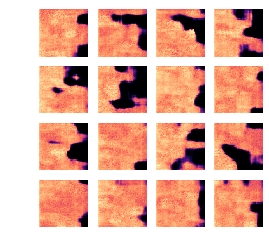

Time taken 167.5048713684082 sec
INFO:tensorflow:Restoring parameters from checkpoints/model


KeyboardInterrupt: 

In [18]:
# Can exit any time because model saves after every epoch
try:
    saver.restore(sess, "checkpoints.model")
except: 
    print("Saved checkpoint invalid, saving new checkpoint")
    saver.save(sess, "checkpoints/model")

while True:
    saver.restore(sess, "checkpoints/model")
    runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images, getEpoch, 
                increment, ranEpoch, 0.05)
    saver.save(sess, "checkpoints/model")

In [ ]:
print(sess.run(images).shape)

In [ ]:
generate_and_save_images(sess.run(getEpoch))

In [ ]:
testAudio(images)

In [ ]:
while(kernel is dead):
    plant_a_new_seed()